

# Exploratory Data Analysis (EDA) for Kaggle's Time Series Forecasting Competition Data
### [Store Sales - Time Series Forecasting](https://www.kaggle.com/competitions/store-sales-time-series-forecasting)

Our dataset hails from Corporación Favorita, a prominent grocery retailer based in Ecuador, and it presents  information encompassing dates, store details, item specifics, promotions, and unit sales. Through the lens of machine learning, we aim to unravel the intricacies of this data and craft robust models capable of forecasting unit sales for thousands of items across diverse Favorita stores.

By thoroughly exploring the data, participants gain valuable insights into the patterns, trends, and anomalies that underlie store sales. This initial analysis not only informs the choice of modeling techniques but also guides feature engineering and the formulation of hypotheses.

### Data Files
#### train.csv
The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.
- **store_nbr** identifies the store at which the products are sold.
- **family** identifies the type of product sold.
- **sales** gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
- **onpromotion** gives the total number of items in a product family that were being promoted at a store at a given date.
#### stores.csv
This dataset provides store metadata, including information about the city, state, store type, and cluster. The 'cluster' categorizes stores into groups based on their similarities.
#### oil.csv
This file contains daily oil prices, covering the entire timeframe of both the train and test data. It's important to note that Ecuador's economy is highly susceptible to fluctuations in oil prices, making this data significant for analysis.
#### holidays_events.csv
This dataset includes information about holidays and events, along with relevant metadata. 
- **transferred** column,indicates if a holiday was officially transferred to another date by the government. If a holiday is marked as transferred, it officially falls on a specific calendar day but was celebrated on a different date.

#### Notes:
 - Salaries within the public sector are distributed biweekly, occurring on the 15th day and the final day of each month. This timing has the potential to influence supermarket revenues.

 - Ecuador experienced a powerful earthquake measuring 7.8 on the Richter scale on April 16, 2016. In response, communities united in their relief endeavors, contributing items like water and essential supplies. This charitable response significantly impacted supermarket sales for multiple weeks following the seismic event.

In [26]:
import pandas as pd
import plotly.express as px
import plotly.offline as pyo

pyo.init_notebook_mode()
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.filterwarnings("ignore")

# Set the style
plt.style.use("bmh")
# Set palette
sns.set_palette("Dark2")
sns.set_style("whitegrid", {"axes.grid": False})

# Set the size
plt.rcParams["figure.figsize"] = (
    15,
    6,
)
# Format floats to 2 decimal spaces
pd.options.display.float_format = "{:.2f}".format

### Data ETL 

In [27]:
train_df = pd.read_csv("train.csv", index_col=0, parse_dates=["date"])
store_df = pd.read_csv("stores.csv")
oil_df = pd.read_csv("oil.csv", index_col=0, parse_dates=["date"]).reset_index()
holidays_df = pd.read_csv("holidays_events.csv", parse_dates=["date"])

When merging holiday data with other DataFrames, national holidays should be merged only based on the 'date' column, whereas local holidays should be merged based on both the 'city' and 'date' columns. This distinction is crucial for correctly integrating holiday information into other datasets while maintaining accuracy and granularity.

We'll define a function that will condense the holiday information in 4 new columns. The first two columns, 'national_holiday_transfered' and 'national_holiday' are based on whether a holiday is of national significance ('locale' equals 'National') and whether it is transferred ('transferred' is True or False). The 'local_holiday_transfered' and 'local_holiday' columns represent the same conditions but for holidays that are not national.

In [28]:
def declare_holidays(row):
    is_national = row["locale"] == "National"
    is_transferred = row["transferred"]
    return (
        is_national and is_transferred,
        is_national and not is_transferred,
        not is_national and is_transferred,
        not is_national and not is_transferred,
    )


(
    holidays_df[
        [
            "national_holiday_transfered",
            "national_holiday",
            "local_holiday_transfered",
            "local_holiday",
        ]
    ]
) = holidays_df.apply(declare_holidays, axis=1, result_type="expand")
holidays_df.head()

date     type    locale locale_name                    description  \
0 2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1 2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2 2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3 2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4 2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  national_holiday_transfered  national_holiday  \
0        False                        False             False   
1        False                        False             False   
2        False                        False             False   
3        False                        False             False   
4        False                        False             False   

   local_holiday_transfered  local_holiday  
0                     False           True  
1                     False           True  
2                     False           True  
3                     False           True  
4                     False           True

In [29]:
train_complete_data = (
    train_df.merge(store_df, on="store_nbr", how="left")
    .merge(oil_df, on="date", how="left")
    .merge(
        holidays_df.query("locale == 'National'")[
            ["date", "national_holiday_transfered", "national_holiday"]
        ],
        on="date",
        how="left",
    )
    .merge(
        holidays_df.query("locale != 'National'")[
            ["date", "locale_name", "local_holiday_transfered", "local_holiday"]
        ],
        left_on=["date", "city"],
        right_on=["date", "locale_name"],
        how="left",
    )
    .drop("locale_name", axis=1)
)
train_complete_data[
    [
        "national_holiday_transfered",
        "national_holiday",
        "local_holiday_transfered",
        "local_holiday",
    ]
] = train_complete_data[
    [
        "national_holiday_transfered",
        "national_holiday",
        "local_holiday_transfered",
        "local_holiday",
    ]
].fillna(
    False
)

# Incorporate pay day information
train_complete_data["pay_day"] = (
    train_complete_data["date"].dt.strftime("%d") == "15"
) | train_complete_data["date"].dt.is_month_end

# Let's add a few time-related columns for the ease of temporal analysis
train_complete_data = train_complete_data.assign(
    year=train_df["date"].dt.year,
    date_no_year=train_df["date"].dt.strftime("%m-%d"),
    day_name=train_df["date"].dt.day_name(),
)
train_complete_data.head()

date  store_nbr      family  sales  onpromotion   city      state  \
0 2013-01-01          1  AUTOMOTIVE   0.00            0  Quito  Pichincha   
1 2013-01-01          1   BABY CARE   0.00            0  Quito  Pichincha   
2 2013-01-01          1      BEAUTY   0.00            0  Quito  Pichincha   
3 2013-01-01          1   BEVERAGES   0.00            0  Quito  Pichincha   
4 2013-01-01          1       BOOKS   0.00            0  Quito  Pichincha   

  type  cluster  dcoilwtico  national_holiday_transfered  national_holiday  \
0    D       13         NaN                        False              True   
1    D       13         NaN                        False              True   
2    D       13         NaN                        False              True   
3    D       13         NaN                        False              True   
4    D       13         NaN                        False              True   

   local_holiday_transfered  local_holiday  pay_day    year date_no_year  \
0                     False          False    False 2013.00        01-01   
1                     False          False    False 2013.00        01-01   
2                     False          False    False 2013.00        01-01   
3                     False          False    False 2013.00        01-01   
4                     False          False    False 2013.00        01-01   

  day_name  
0  Tuesday  
1  Tuesday  
2  Tuesday  
3  Tuesday  
4  Tuesday

And there we have it—the comprehensive dataset that encompasses all available information regarding sales, stores, holidays, and gas prices on the respective dates.

### Sales by Product Family

In [30]:
display(
    train_complete_data[["store_nbr", "sales", "onpromotion"]].describe(
        percentiles=[0.25, 0.5, 0.75, 0.99]
    )
)
print("The data has {} points.".format(train_complete_data.shape[0]))
print(
    "There are {} different product families, sold in {} different stores.".format(
        train_complete_data["family"].nunique(),
        train_complete_data["store_nbr"].nunique(),
    )
)

store_nbr      sales  onpromotion
count 3008280.00 3008280.00   3008280.00
mean       27.50     358.26         2.61
std        15.59    1103.49        12.26
min         1.00       0.00         0.00
25%        14.00       0.00         0.00
50%        28.00      11.00         0.00
75%        41.00     196.00         0.00
99%        54.00    5513.99        55.00
max        54.00  124717.00       741.00

The data has 3008280 points.
There are 33 different product families, sold in 54 different stores.


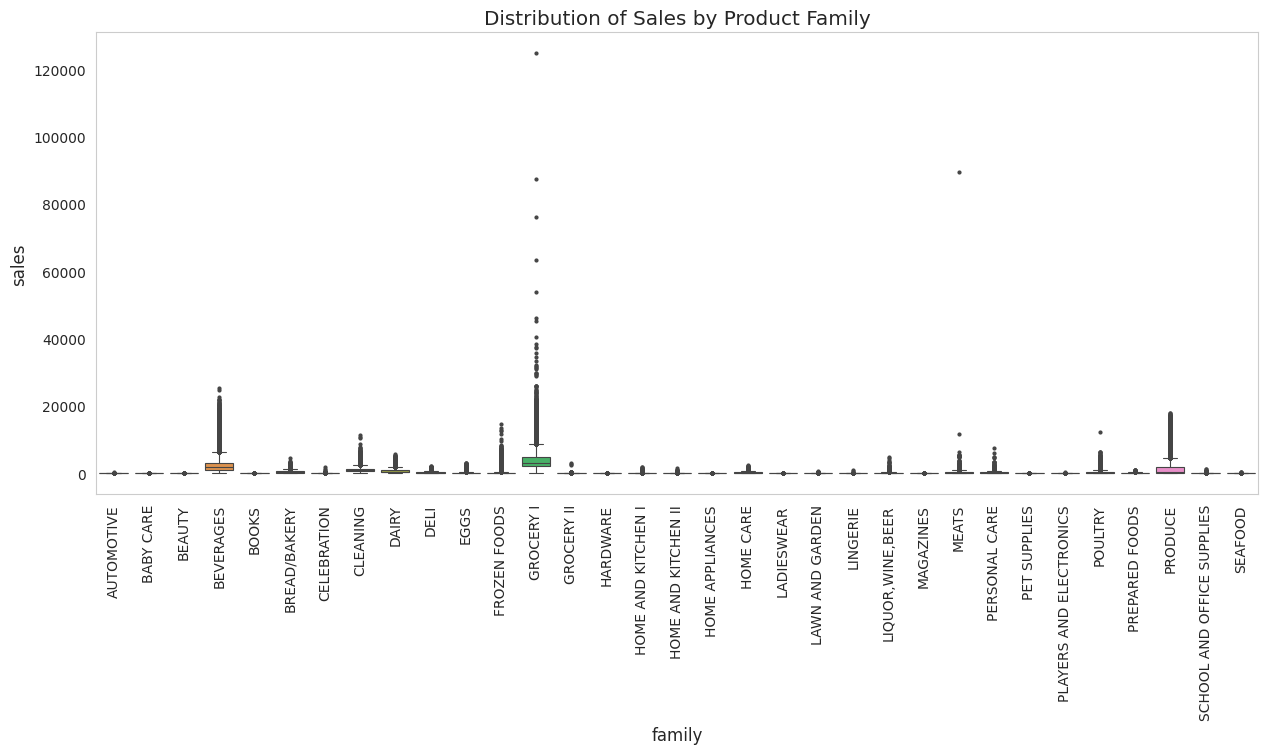

In [31]:
# Explore the distribution of sales by product family:
flierprops = dict(marker=".", markersize=4)
sns.boxplot(
    data=train_complete_data,
    x="family",
    y="sales",
    linewidth=0.8,
    flierprops=flierprops,
)
plt.xticks(rotation=90)
plt.title("Distribution of Sales by Product Family")
plt.show()

In [32]:
# Count outlier candidates using IQR Method (Interquartile Range):
q1, q3 = train_df["sales"].quantile(0.25), train_df["sales"].quantile(0.75)
outlier_percentage = (
    train_df[
        (train_df["sales"] < (q1 - 1.5 * (q3 - q1)))
        | (train_df["sales"] > (q3 + 1.5 * (q3 - q1)))
    ].shape[0]
    / train_df.shape[0]
) * 100
print(
    f"There are {outlier_percentage:.2f}% points that are considered outliers according to IQR method."
)

There are 14.90% points that are considered outliers according to IQR method.


The presence of 14.90% of data points identified as outliers using the IQR method suggests that a significant portion of the dataset deviates noticeably from the central distribution. While some of these deviations could result from data defects, it's worth considering that certain instances might significantly differ from the majority and potentially offer valuable insights or anomalies that require further investigation. These anomalies could have a substantial impact on how we interpret or model the overall dataset.

Furthermore, it's possible that the assumption of a uniform distribution for sales across all product families may not hold true. Some strata within the data may exhibit unique characteristics. 

Overall, the data displays noticeable irregularities in its sales figures, prompting the need to distinguish between potential anomalies and justified outliers.

In [33]:
# Let's explore those extriemly high sales:
high_sales_df = train_complete_data.query("sales >= 60000").reset_index(drop=True)
high_sales_df["date"]

0   2016-04-18
1   2016-04-21
2   2016-04-26
3   2016-05-02
4   2016-10-07
Name: date, dtype: datetime64[ns]

It's important to note that all dates with sales exceeding 60,000 occurred after the earthquake. As already indicated, this correlation is caused by relief efforts in items such as water and essential supplies. This charitable response had a substantial and lasting impact on supermarket sales for several weeks following the seismic event.

As earthquakes are unpredictable, this serves as an illustration of the impact that natural catastrophes can have on sales. However, it is important to note that such events do not significantly contribute to the modeling of regular sales patterns.

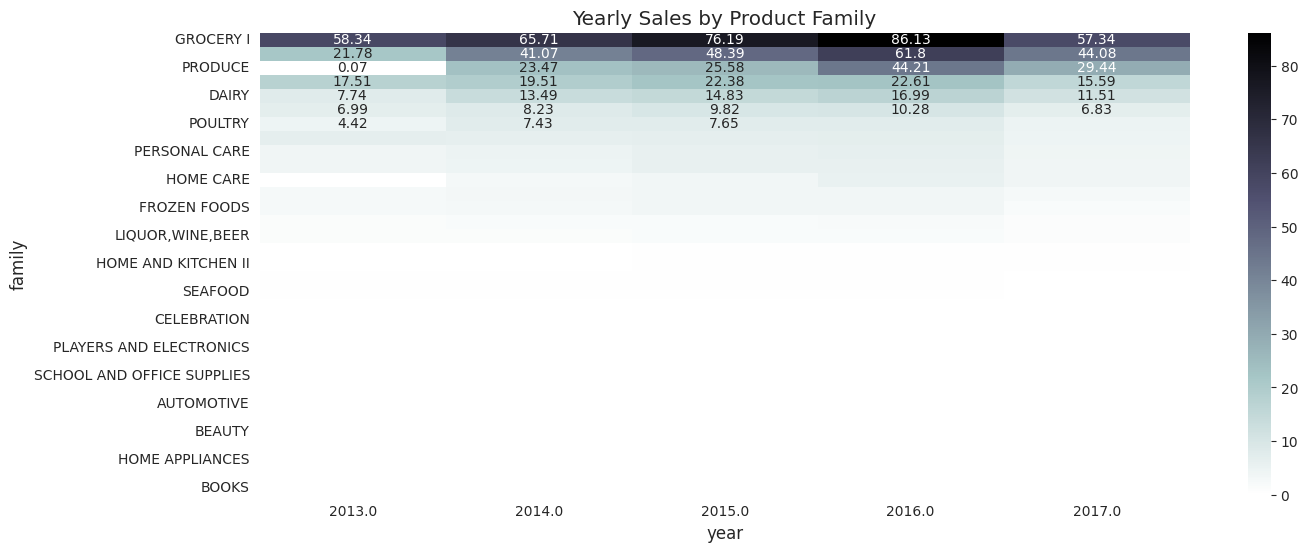

In [34]:
# What family sells the most?
yearly_sum_sales = (
    train_complete_data.groupby(["family", "year"])["sales"].sum().reset_index()
)
sns.heatmap(
    data=yearly_sum_sales.pivot(index="family", columns="year", values="sales")
    .div(1000000)
    .round(2)
    .sort_values(by=2017, ascending=False),
    annot=True,
    cmap="bone_r",
    fmt="g",
)
plt.title("Yearly Sales by Product Family")
plt.show()

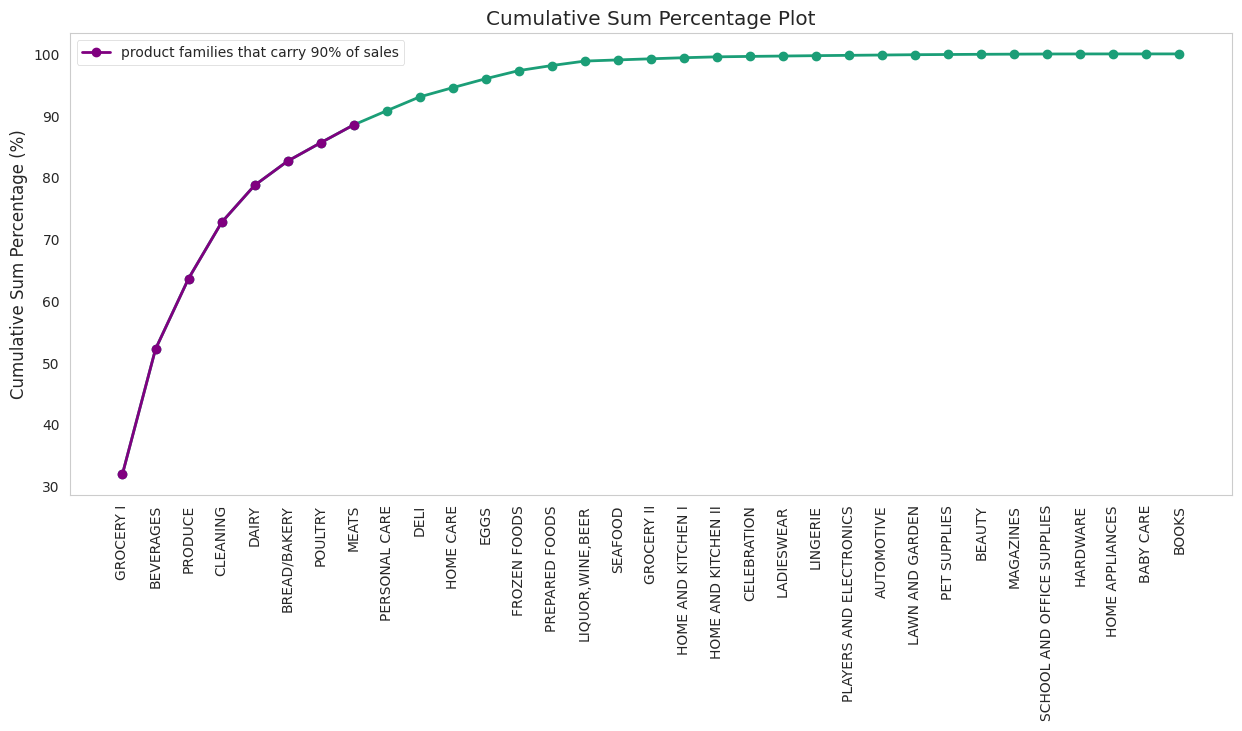

In [35]:
sum_sales = (
    yearly_sum_sales.groupby("family")["sales"].sum().sort_values(ascending=False)
)
cumulative_sum_percentage = (sum_sales.cumsum() / sum_sales.sum()) * 100

plt.plot(cumulative_sum_percentage, marker="o", linestyle="-")
plt.plot(
    cumulative_sum_percentage[cumulative_sum_percentage < 90],
    marker="o",
    linestyle="-",
    color="purple",
    label="product families that carry 90% of sales",
)

plt.title("Cumulative Sum Percentage Plot")
plt.ylabel("Cumulative Sum Percentage (%)")
plt.xticks(rotation=90)
plt.legend()
plt.show()

Over the years, the majority of sales have consistently been concentrated within a select few product families, namely:
- GROCERY I  
- BEVERAGES
- PRODUCE
- CLEANING
- DAIRY
- BREAD/BAKERY
- POULTRY
- and MEATS

These product families collectively account for more than 90% of all sales.

### Sales by Store

In Store dataset, we have a diverse range of unique values within each of the categorical variables. Specifically, 
- **'store_nbr'** category comprises 54 distinct store identifiers, reflecting the extensive variety of stores included in our data 
- **'city'** and **'state'** categories, representing the locations of these stores, exhibits 22 cities in 16 states, highlighting the geographical spread of these establishments across different cities
- the **'type'** category consists of 5 unique values ['A', 'B', 'C','D', 'E'], suggesting different store types or formats. 
- the **'cluster'** category demonstrates 17 unique values, signifying the classification of stores into various clusters based on certain criteria. 
These distinct values across categories provide valuable insights into the diversity and complexity of our dataset, facilitating a deeper understanding of the data's characteristics and patterns.

In [36]:
display(store_df.nunique(), store_df["type"].unique())

store_nbr    54
city         22
state        16
type          5
cluster      17
dtype: int64

array(['D', 'B', 'C', 'E', 'A'], dtype=object)

In [37]:
fig = px.sunburst(
    train_complete_data,
    path=["state", "city"],
    values="sales",
)
fig.update_layout(
    title_text="Total Sales by City and State",
    title_x=0.5,
    autosize=False,
    width=700,
    height=700,
)
fig.show()

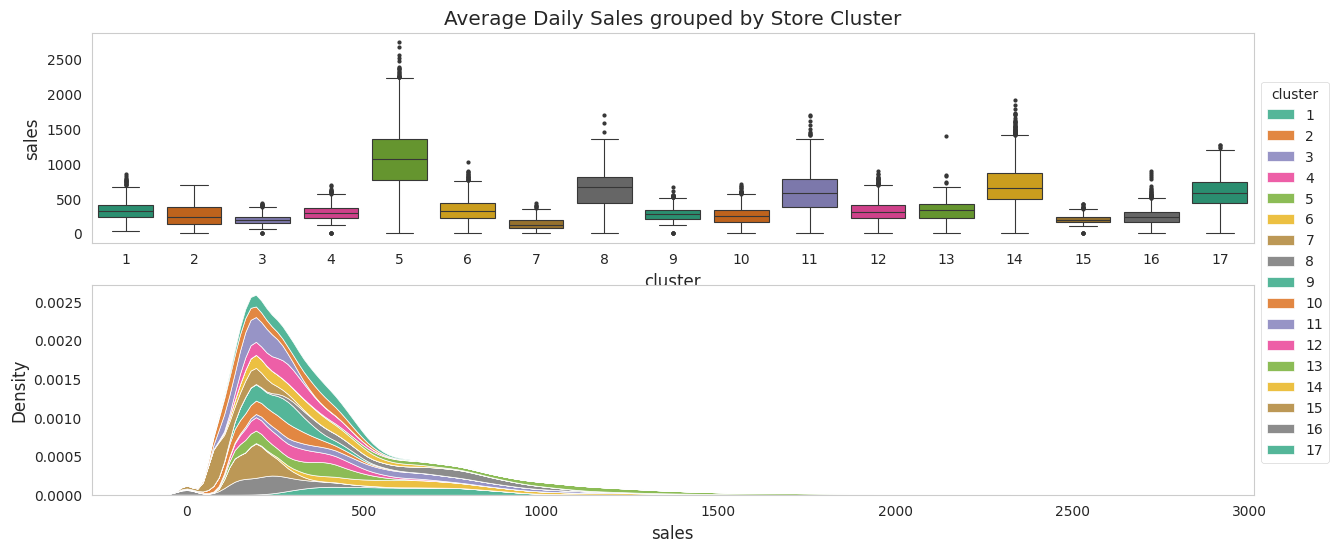

In [38]:
fig, ax = plt.subplots(ncols=1, nrows=2)
ax[0].title.set_text("Average Daily Sales grouped by Store Cluster")
sns.boxplot(
    data=train_complete_data.groupby(["cluster", "year", "date_no_year"])["sales"]
    .mean()
    .reset_index(),
    y="sales",
    x="cluster",
    ax=ax[0],
    palette="Dark2",
    linewidth=0.8,
    flierprops=flierprops,
)
sns.kdeplot(
    data=train_complete_data.groupby(["cluster", "year", "date_no_year"])["sales"]
    .mean()
    .reset_index(),
    x="sales",
    hue="cluster",
    ax=ax[1],
    palette="Dark2",
    multiple="stack",
)
sns.move_legend(ax[1], "upper left", bbox_to_anchor=(1, 2))
plt.show()

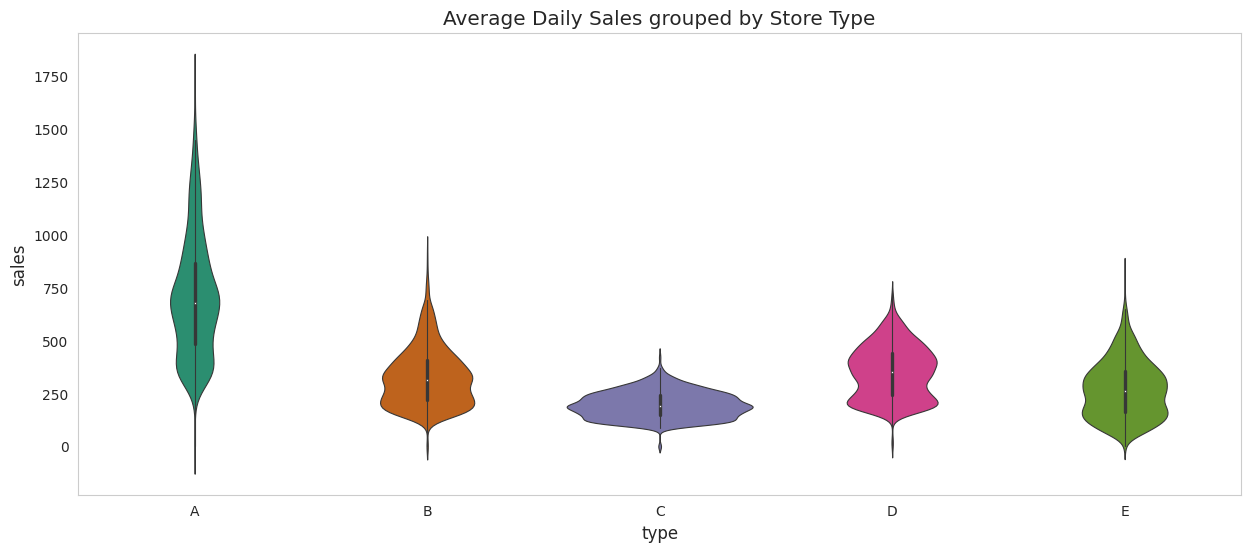

In [39]:
sns.violinplot(
    data=train_complete_data.groupby(["type", "date"])["sales"].mean().reset_index(),
    y="sales",
    x="type",
    linewidth=0.8,
)
plt.title("Average Daily Sales grouped by Store Type")
plt.show()

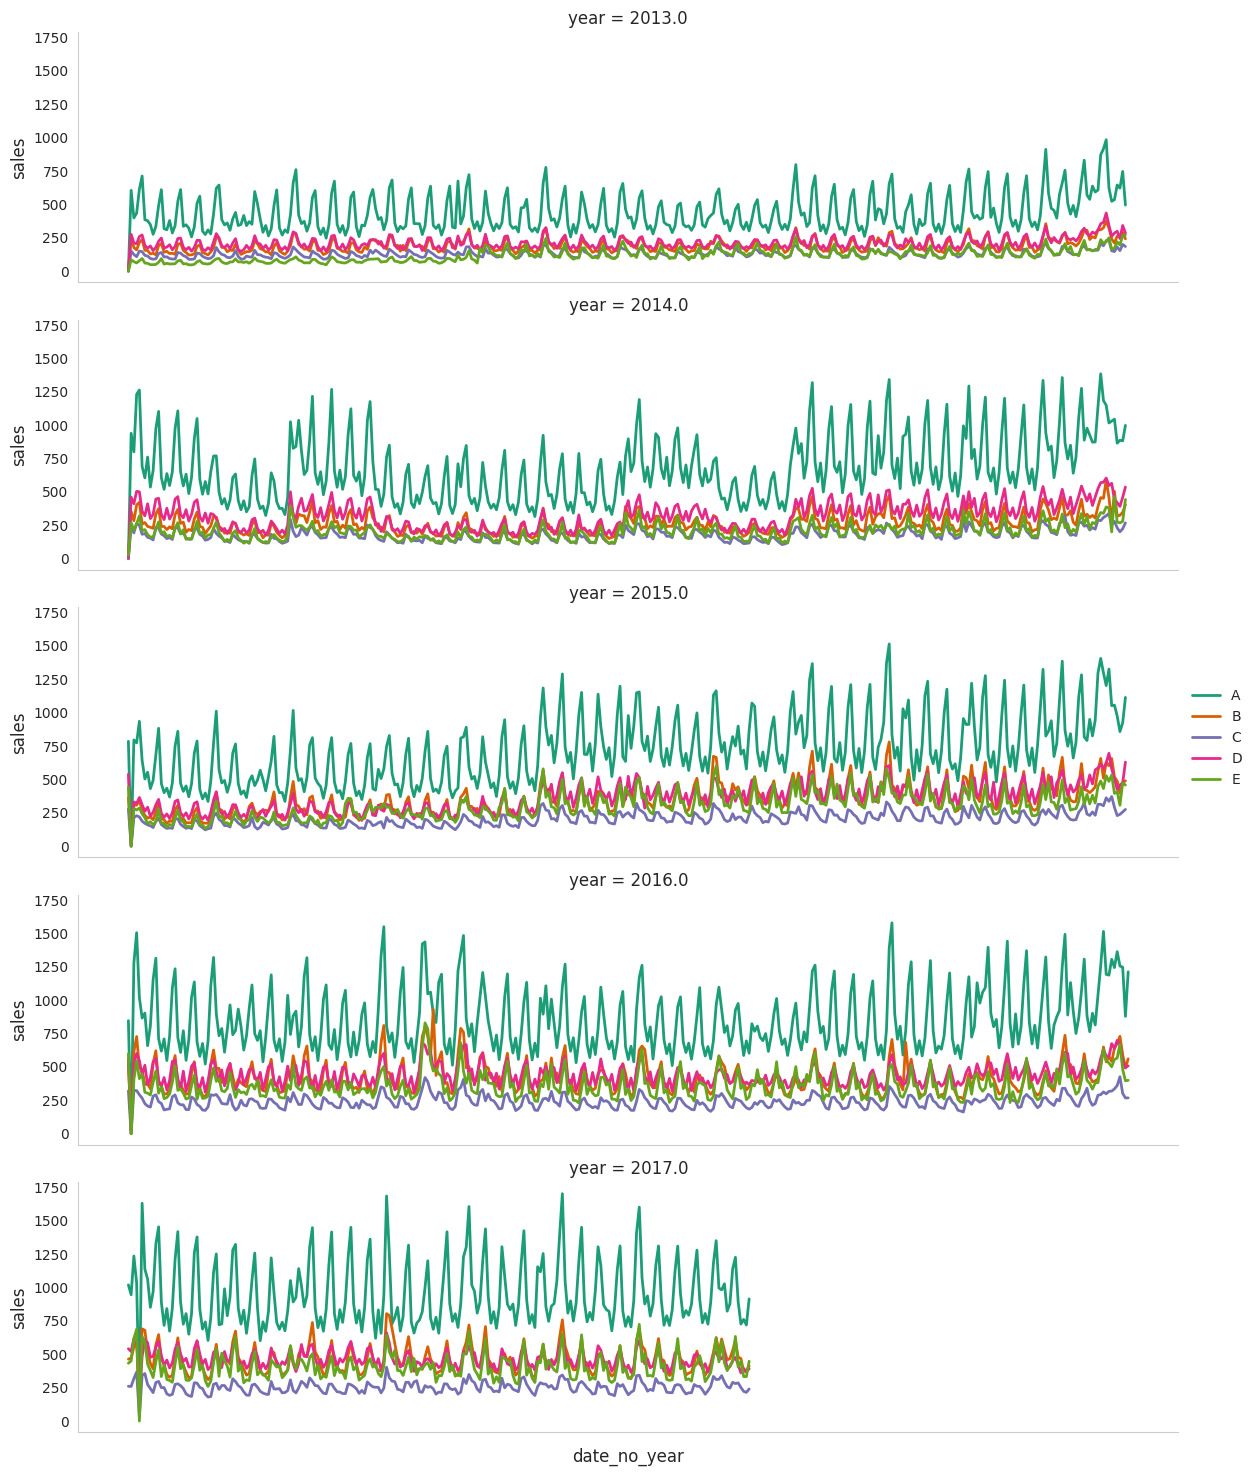

In [40]:
data = (
    train_complete_data.groupby(["type", "year", "date_no_year"])["sales"]
    .mean()
    .reset_index()
)
g = sns.FacetGrid(data, row="year", height=3, aspect=4)
g.map_dataframe(sns.lineplot, x="date_no_year", y="sales", hue="type")
g.add_legend()
g.set_xticklabels(rotation=90)
plt.show()

### Oil data

The influence of oil prices on the sales of different products in small or developing countries is intertwined with various economic, industrial, and policy factors. While rising oil prices can lead to increased costs and reduced sales in some sectors, they can also have positive effects in others. The overall impact depends on the specific circumstances of each country and its economy. 

Ecuador can be considered an oil-dependent country. Oil has historically been a crucial component of Ecuador's economy and government revenues. The country is one of the smallest OPEC (Organization of the Petroleum Exporting Countries) members, and oil exports have played a significant role in its economic stability and fiscal policy.

Are there missing values for oil prices?
 date           0
dcoilwtico    43
dtype: int64


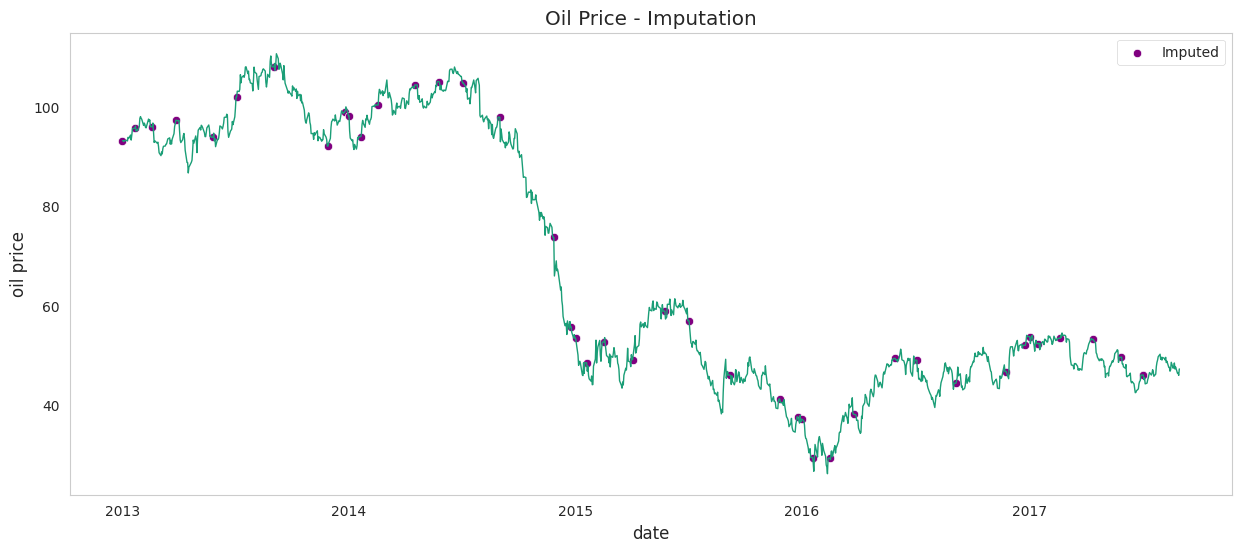

In [41]:
# Handling missing data:
print(
    "Are there missing values for oil prices?\n",
    oil_df[["date", "dcoilwtico"]].drop_duplicates().isna().sum(),
)
# Impute using foward and backward method and create a flag that will mark imputed points.
# This combination of ffill() followed by bfill() ensures that missing values are filled using
# the nearest available values both before and after each missing data point, effectively reducing gaps in the data.
oil_df["dcoilwtico_filled"] = oil_df["dcoilwtico"].ffill().bfill()
oil_df["dcoilwtico_impute_flag"] = oil_df["dcoilwtico_filled"] != oil_df["dcoilwtico"]

sns.lineplot(
    data=oil_df,
    y="dcoilwtico_filled",
    x="date",
    lw=1,
)
sns.scatterplot(
    data=oil_df[oil_df["dcoilwtico_impute_flag"]],
    y="dcoilwtico_filled",
    x="date",
    c="purple",
    label="Imputed",
)

plt.ylabel("oil price")
plt.title("Oil Price - Imputation")
plt.show()

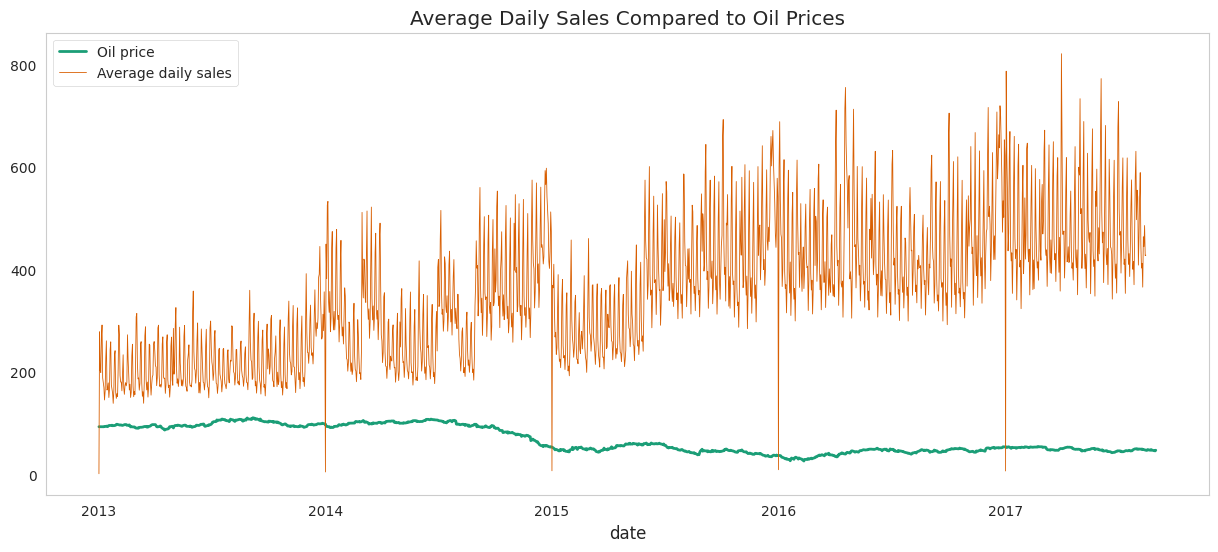

In [42]:
sns.lineplot(data=oil_df, y="dcoilwtico_filled", x="date", label="Oil price")
sns.lineplot(
    data=train_complete_data.groupby("date")["sales"].mean().reset_index(),
    x="date",
    y="sales",
    lw=0.6,
    label="Average daily sales",
)
plt.ylabel("")
plt.title("Average Daily Sales Compared to Oil Prices")
plt.show()

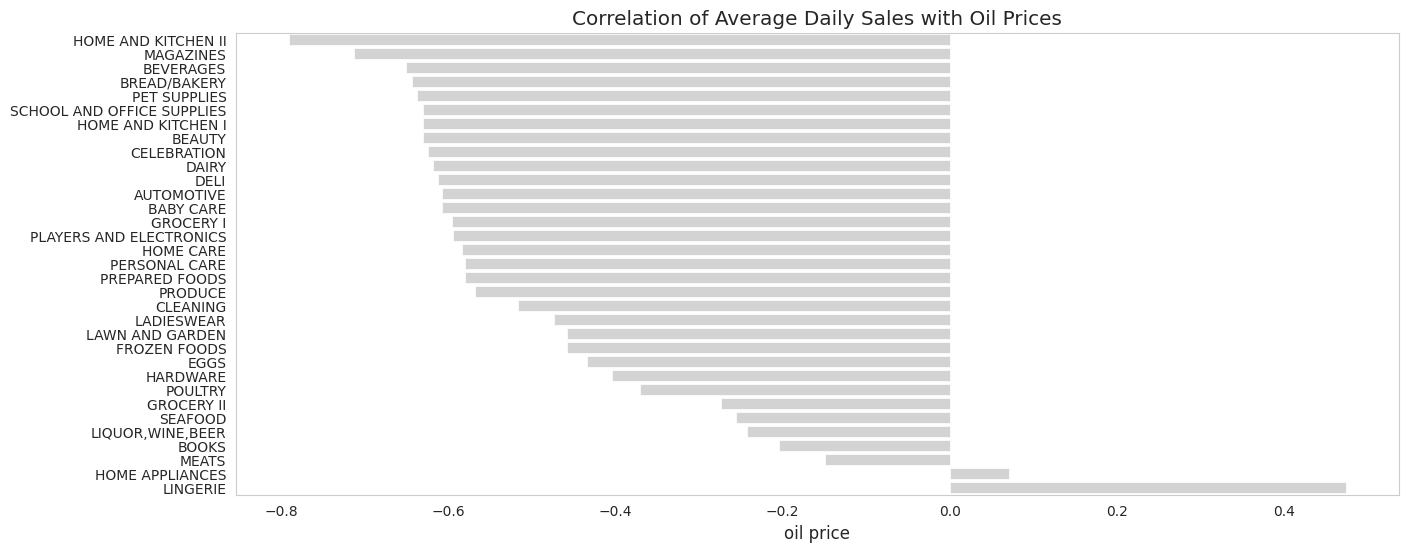

In [43]:
# Correlation by family:
oil_and_avg_sales_corr = (
    train_complete_data.groupby(["date", "family"])["sales"]
    .mean()
    .reset_index()
    .pivot(values="sales", index="date", columns="family")
    .reset_index()
    .merge(oil_df, on="date")
    .drop(["date", "dcoilwtico", "dcoilwtico_impute_flag"], axis=1)
    .corr("spearman")[["dcoilwtico_filled"]]
    .reset_index()
    .sort_values(by="dcoilwtico_filled")
)
sns.barplot(
    data=oil_and_avg_sales_corr[:-1],
    x="dcoilwtico_filled",
    y="index",
    color="lightgray",
)
plt.ylabel("")
plt.xlabel("oil price")
plt.title("Correlation of Average Daily Sales with Oil Prices")
plt.show()
# Considering the skewness of the data, Spearman's correlations is more suited since it is based on
# the ranked values of the variables rather than their actual values.
# Like Kendall's Tau, it is less sensitive to outliers and non-normality compared to Pearson correlation (inear correlation coeficient).

Categories like "HOME AND KITCHEN II," "MAGAZINES," "BEVERAGES," exhibit strong negative correlations with oil prices. This suggests that as oil prices increase, the average daily sales in these categories tend to decrease significantly. The negative correlation implies that these categories may be sensitive to changes in oil prices, possibly due to factors like transportation costs or consumer spending patterns.

If we pay special attention to product families that carry the majority of the sales, they carry moderate to weak negative correlation indicating that as oil prices increase, sales of those items tend to decrease. "GROCERY I" also displays a negative correlation with oil prices. This is significant as grocery sales often reflect essential consumer spending patterns. When oil prices rise, it appears that consumers may reduce their spending on grocery items within this category.

Interestingly, the "LINGERIE" category shows a positive correlation of moderate intensity with oil prices. This implies that as oil prices rise, sales in the "LINGERIE" category tend to increase. This positive correlation may indicate that consumer spending on certain luxury or discretionary items like lingerie is positively influenced by economic factors associated with higher oil prices.

### Exploring the Relationship Between Sales and _On Promotion_

Onpromotion indicates the total count of items within a product family that were actively being promoted at a specific store on a particular date.

The impact of the "onpromotion" variable on sales can vary significantly across different product families, spanning from everyday groceries to luxury goods. In the case of groceries and everyday essentials, promotions tend to have a more direct and immediate influence on sales. Customers are often price-sensitive when it comes to these products, and promotions such as discounts or special offers can incentivize increased purchases. Therefore, for product families like groceries, a higher "onpromotion" count is likely to result in a notable boost in sales.

On the other hand, for luxury goods, the relationship between promotions and sales is more complex. Luxury items are often associated with exclusivity and prestige, and excessive discounting can diminish their perceived value. In this context, promotions may need to be carefully executed to maintain the brand's image. Limited-time promotions or exclusive offers may drive short-term sales spikes, but a consistent high "onpromotion" count could potentially erode the perceived luxury status of these goods. Therefore, for luxury product families, the impact of "onpromotion" on sales may be less straightforward and may require a more nuanced marketing approach.

So, if we take a look at avg_sales_onpromotion, it will contain a DataFrame that shows the average sales for each combination of "family" and "onpromotion," sorted in descending order of average sales. This can be useful for analyzing which product families and promotion statuses have the highest average sales.


count  mean   std  min  25%  50%   75%    max
family                                                                     
GROCERY I                  91160.00 21.16 33.66 0.00 0.00 5.00 36.00 741.00
PRODUCE                    91160.00 12.27 41.10 0.00 0.00 0.00  2.00 252.00
BEVERAGES                  91160.00 10.02 16.93 0.00 0.00 2.00 15.00 342.00
DAIRY                      91160.00  8.02 19.62 0.00 0.00 1.00  6.00 167.00
CLEANING                   91160.00  7.28 13.34 0.00 0.00 1.00 10.00 285.00
DELI                       91160.00  6.42 15.10 0.00 0.00 0.00  4.00  81.00
BREAD/BAKERY               91160.00  3.69 10.55 0.00 0.00 0.00  3.00 104.00
MEATS                      91160.00  3.35 10.40 0.00 0.00 0.00  0.00  56.00
PERSONAL CARE              91160.00  2.72  4.67 0.00 0.00 0.00  5.00  99.00
POULTRY                    91160.00  2.49  7.90 0.00 0.00 0.00  0.00  48.00
HOME CARE                  91160.00  2.17  4.23 0.00 0.00 0.00  2.00  71.00
EGGS                       91160.00  2.15  6.07 0.00 0.00 0.00  1.00  32.00
FROZEN FOODS               91160.00  1.39  3.20 0.00 0.00 0.00  2.00  33.00
HOME AND KITCHEN I         91160.00  0.52  1.66 0.00 0.00 0.00  0.00  31.00
LIQUOR,WINE,BEER           91160.00  0.51  1.36 0.00 0.00 0.00  0.00  27.00
SEAFOOD                    91160.00  0.43  1.23 0.00 0.00 0.00  0.00   7.00
PREPARED FOODS             91160.00  0.41  1.34 0.00 0.00 0.00  0.00  14.00
HOME AND KITCHEN II        91160.00  0.36  0.91 0.00 0.00 0.00  0.00  20.00
SCHOOL AND OFFICE SUPPLIES 91160.00  0.16  0.96 0.00 0.00 0.00  0.00  14.00
BEAUTY                     91160.00  0.15  0.44 0.00 0.00 0.00  0.00  10.00
LAWN AND GARDEN            91160.00  0.12  0.80 0.00 0.00 0.00  0.00  15.00
GROCERY II                 91160.00  0.08  0.46 0.00 0.00 0.00  0.00   7.00
CELEBRATION                91160.00  0.07  0.56 0.00 0.00 0.00  0.00  14.00
AUTOMOTIVE                 91160.00  0.05  0.34 0.00 0.00 0.00  0.00   8.00
PET SUPPLIES               91160.00  0.04  0.20 0.00 0.00 0.00  0.00   6.00
LINGERIE                   91160.00  0.03  0.25 0.00 0.00 0.00  0.00  12.00
PLAYERS AND ELECTRONICS    91160.00  0.02  0.34 0.00 0.00 0.00  0.00  16.00
LADIESWEAR                 91160.00  0.02  0.37 0.00 0.00 0.00  0.00  19.00
MAGAZINES                  91160.00  0.00  0.09 0.00 0.00 0.00  0.00   6.00
HARDWARE                   91160.00  0.00  0.05 0.00 0.00 0.00  0.00   4.00
HOME APPLIANCES            91160.00  0.00  0.03 0.00 0.00 0.00  0.00   1.00
BABY CARE                  91160.00  0.00  0.02 0.00 0.00 0.00  0.00   1.00
BOOKS                      91160.00  0.00  0.00 0.00 0.00 0.00  0.00   0.00

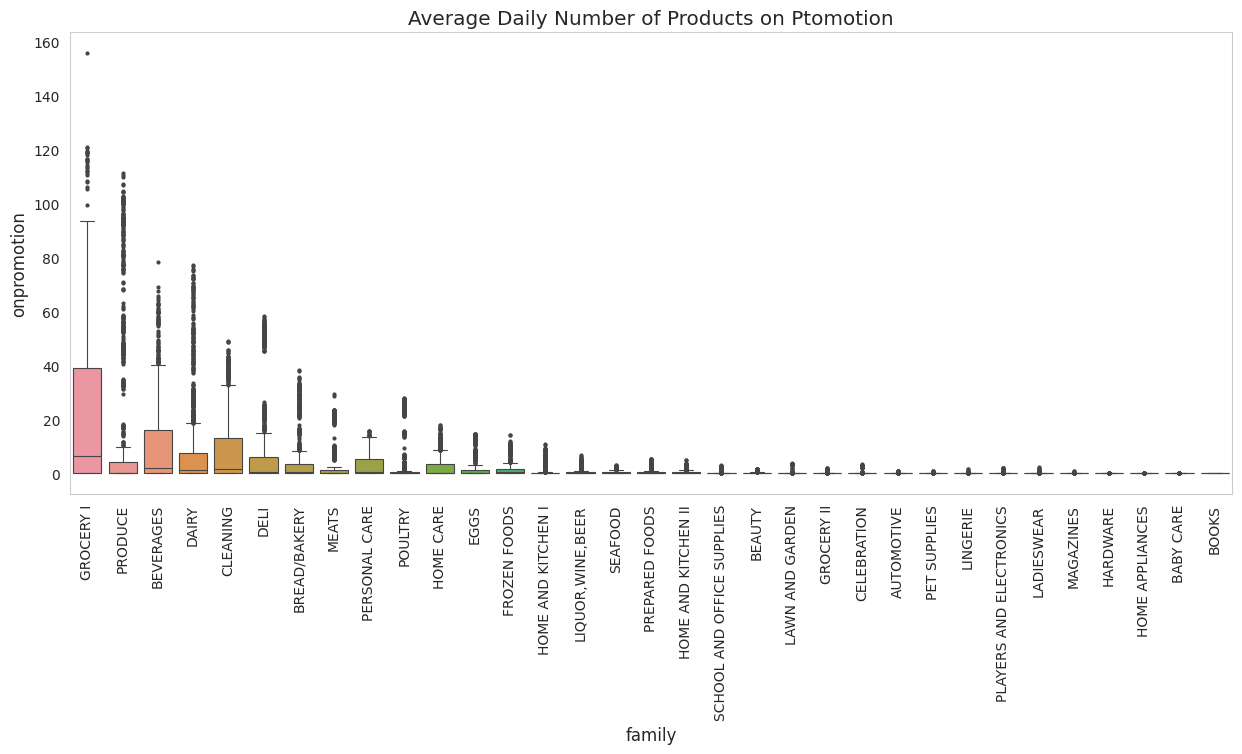

In [101]:
# Average on promotion by family:
display(
    train_complete_data.groupby("family")["onpromotion"]
    .describe()
    .sort_values(by="mean", ascending=False)
)
# Average daily on promotion by family:
sns.boxplot(
    data=train_complete_data.groupby(["family", "date"])["onpromotion"]
    .mean()
    .reset_index(),
    x="family",
    y="onpromotion",
    order=train_complete_data.groupby("family")["onpromotion"]
    .describe()
    .sort_values(by="mean", ascending=False)
    .index,
    linewidth=0.8,
    flierprops=flierprops,
)
plt.xticks(rotation=90)
plt.title("Average Daily Number of Products on Ptomotion")
plt.show()

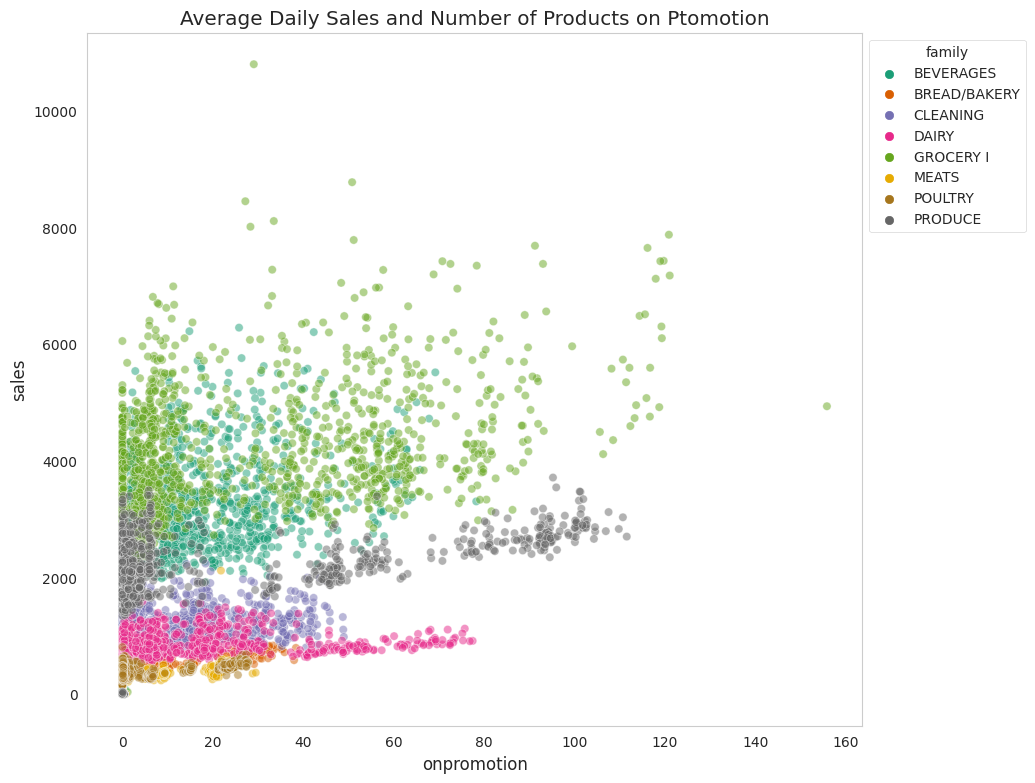

In [95]:
# Average on promotion:
fig, ax = plt.subplots(figsize=(10, 9))
sns.scatterplot(
    train_complete_data.query("family in @dominant_families")
    .groupby(["family", "date"])[["onpromotion", "sales"]]
    .mean()
    .reset_index(),
    x="onpromotion",
    y="sales",
    hue="family",
    alpha=0.5,
)
sns.move_legend(ax, loc="upper left", bbox_to_anchor=(1, 1))
plt.title("Average Daily Sales and Number of Products on Ptomotion")
plt.show()

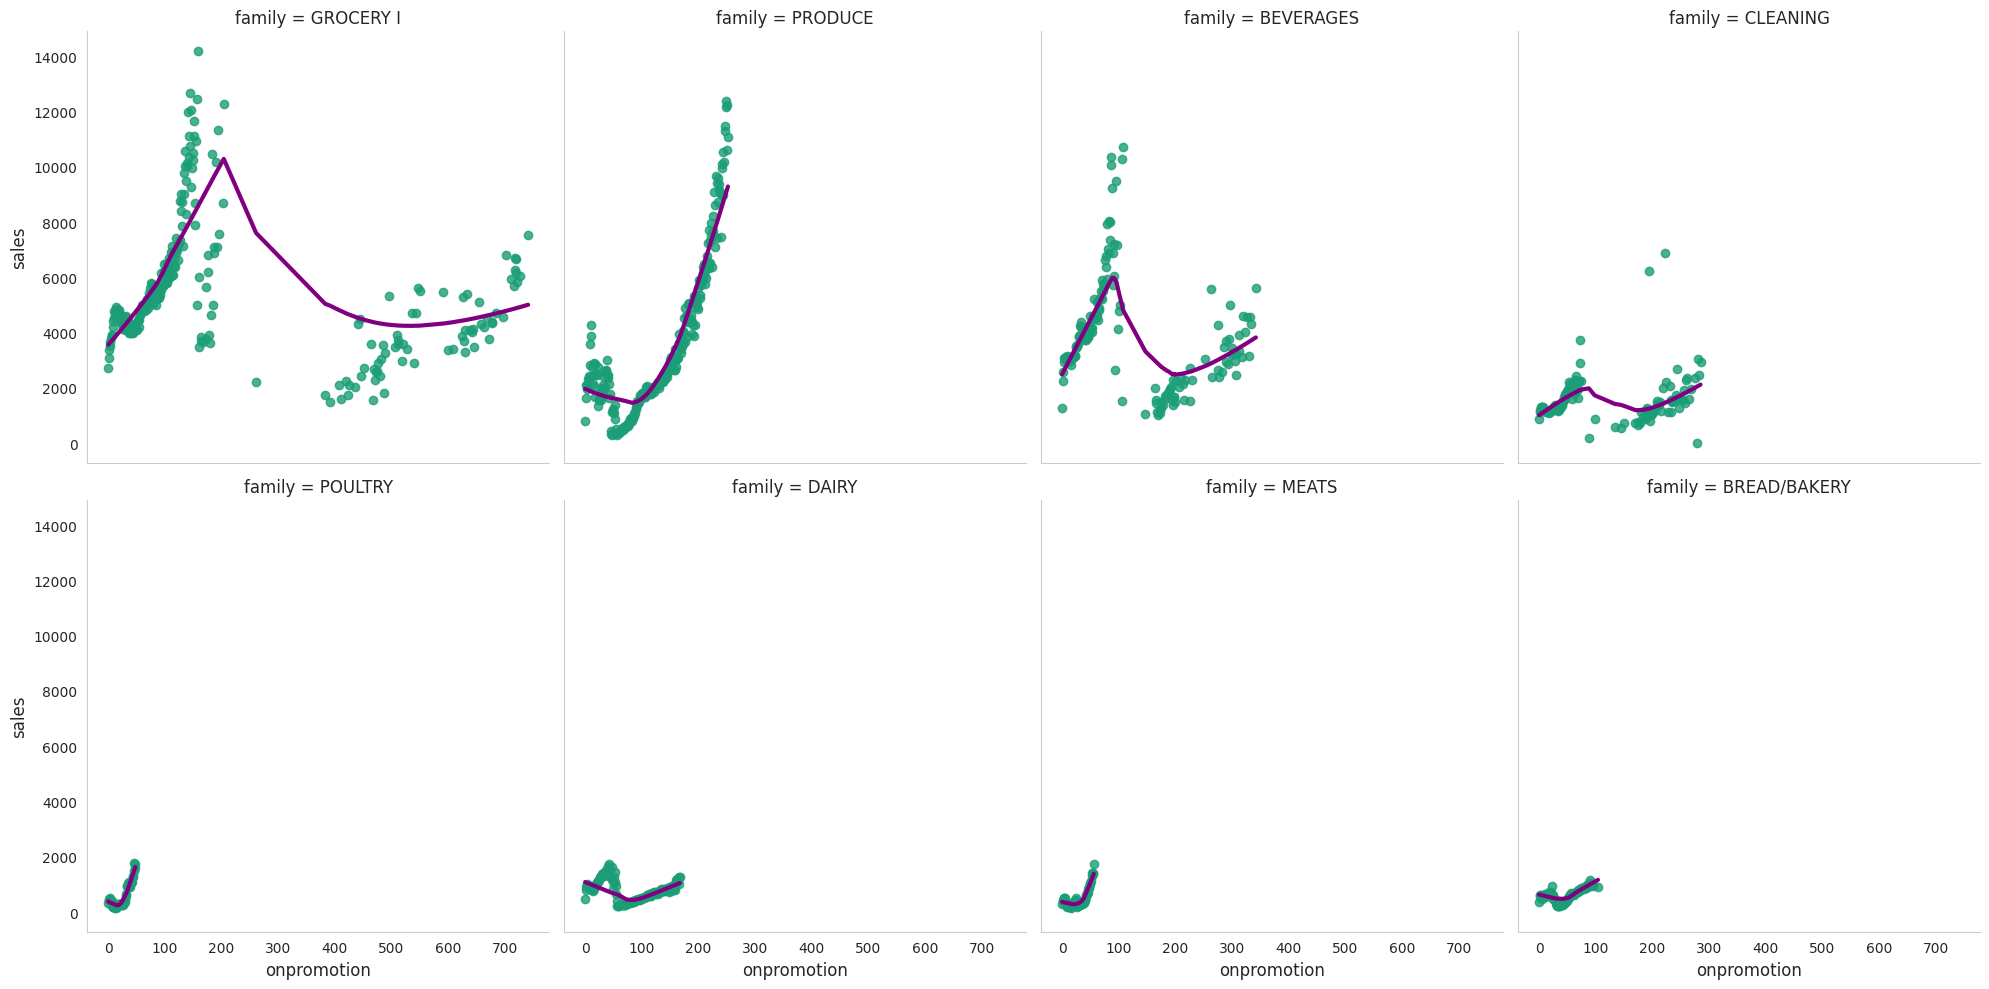

In [96]:
avg_sales_onpromotion = (
    train_complete_data.groupby(["family", "onpromotion"])["sales"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)
sns.lmplot(
    data=avg_sales_onpromotion.query("family in @dominant_families"),
    x="onpromotion",
    y="sales",
    col="family",
    col_wrap=4,
    lowess=True,
    line_kws={"color": "purple"},
)
plt.show()

A discernible relationship between average sales and the number of items on promotion is evident across various product families; however, intriguingly, there appears to be clustering within these patterns that might be attributed to the influence of an additional variable. While onpromotion clearly impacts sales, the presence of distinct clusters within these trends suggests the presence of an underlying factor that merits further investigation. This finding underscores the complexity of sales dynamics, suggesting that factors beyond promotions, such as seasonality, pricing strategies, or customer behavior, could be contributing to the observed clustering patterns. In-depth analysis and additional data exploration will be essential to uncover the hidden variables driving these intriguing variations in average sales among different product families.

### Temporal fluctuation

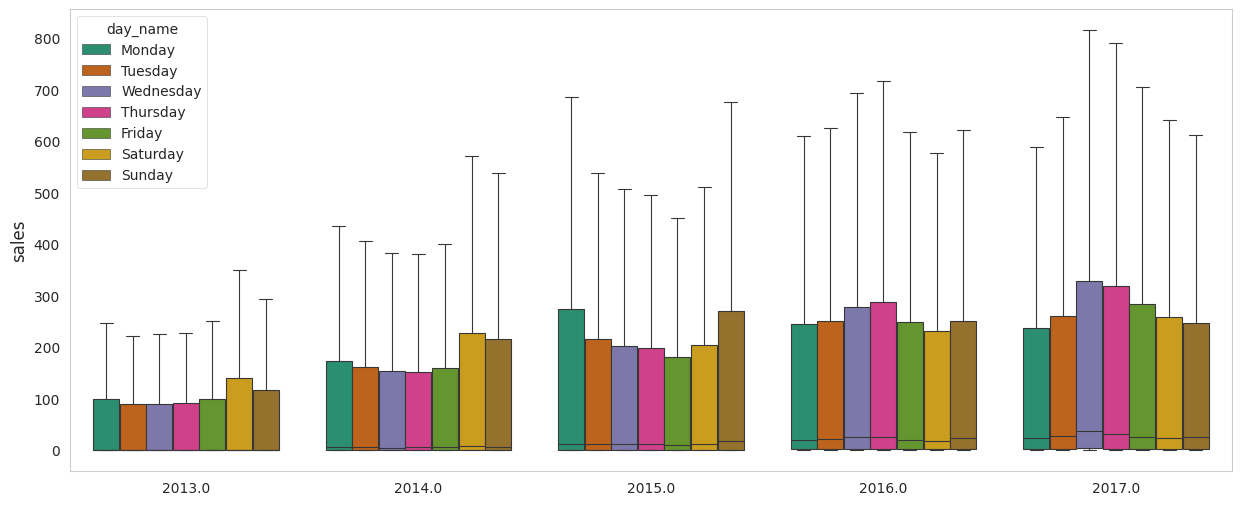

In [102]:
ax = sns.boxplot(
    data=train_complete_data,
    hue="day_name",
    y="sales",
    x="year",
    hue_order=[
        "Monday",
        "Tuesday",
        "Wednesday",
        "Thursday",
        "Friday",
        "Saturday",
        "Sunday",
    ],
    showfliers=False,
    linewidth=0.8,
)
plt.xlabel("")
plt.show()